In [10]:
#!/usr/bin/env python
# coding: utf-8

# In[1]:


import warnings
warnings.filterwarnings("ignore")


# In[2]:


import cv2
import numpy as np
import torch # 1.9
import torch.nn as nn
from torch.utils.data import Dataset
import numpy as np
import matplotlib.pyplot as plt
import albumentations as A
import os

from sklearn.model_selection import train_test_split


# 導入dicom套件
from pydicom import dcmread
from pydicom.data import get_testdata_files


# In[3]:


def show_image(*img_):
    for i in img_:
        assert i.__class__.__name__ == 'ndarray', 'imput data type should be ndarray'

    plt.figure(figsize=(10,3))
    for i, img in enumerate(list(img_), 1):
        plt.subplot(1,len(img_),i)

        if len(np.shape(img)) == 2 or np.shape(img)[-1] == 1:
            plt.imshow(img, cmap='gray')
        elif len(np.shape(img)) == 3:
            plt.imshow(img)
    plt.show()
    plt.close()


# ### Build torch dataset

# In[4]:


def getAllDataPath(dir_path, imgOnly=False, test_split_size=None):
    
    images = []
    labels = []
    
    for root, dirs, files in os.walk(os.path.abspath(dir_path)):
        for file in sorted(files):
            if '.dcm' in file:
                images.append(os.path.join(root, file))
            elif '.png' in file:
                labels.append(os.path.join(root, file))
    if imgOnly:
        data_list = images
    else:
        data_list = list(zip(images, labels))

    if test_split_size:
        assert type(test_split_size)==float, 'set float to split test set size'
        train, test = train_test_split(data_list,
                         test_size = test_split_size)
        return {'train':train, 'test':test}
    else:
        return {'train':data_list}
        


# In[5]:





# In[6]:


#  https://pytorch.org/tutorials/beginner/basics/data_tutorial.html

class CustomImageDataset(Dataset):
    def __init__(self, imgs_anno_path_list,
                 pseudo_label = False,
                 #dtype, 
#                  dir_path,
                 transform=None):
        self.imgs_anno_path_list = imgs_anno_path_list
        self.transform = transform
        self.pseudo_label = pseudo_label

#   
    def __len__(self):
        return len(self.imgs_anno_path_list)
    
    def __getitem__(self, idx):
        # now = time.time()
        imgOnly = False
        img_anno_path = self.imgs_anno_path_list[idx]

        if type(img_anno_path)==tuple:
#             img_anno_path = [i for i in img_anno_path]
            image = self.getImg(img_anno_path[0])
            mask = self.getImg(img_anno_path[1])
        else:
            image = self.getImg(img_anno_path)
            imgOnly = True
    
        
        if imgOnly:
            if self.transform:        
                transformed = self.transform(image=image)
                image = transformed['image']
            image = np.expand_dims(image, axis=0)
#             image = np.concatenate((image, image, image), axis=0)
            image = torch.Tensor(image)
            return image
        else:
            if self.transform:
                transformed = self.transform(image=image, mask=mask)
                image = transformed['image']
                mask = transformed['mask']
            
            if self.pseudo_label:
                imgType = imgType='CT' if img_anno_path[0].__contains__('CT') else 'MRI'
                mask = self.apply_pseudo_label(imgType, image, mask)

            image = np.expand_dims(image, axis=0)
            image = torch.Tensor(image)

            mask = torch.Tensor(mask) 
            mask = mask.unsqueeze(0)
            return image, mask
    
    def getImg(self, path):
        if path.__contains__('.dcm'):  
            # pydcm read image
            ds = dcmread(path)
            file = ds.pixel_array
            # image process
            file = cv2.medianBlur(file, 5)
            file = cv2.normalize(file, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)

        elif path.__contains__('.png'):
            file = cv2.imread(path)[...,0]
            file = file.astype('float32') # 調整格式以配合albumentation套件需求

            if 'MRI' in path:
                file[file!=63] = 0.
                file[file!=0] = 1.
            elif 'CT' in path:
                file /= 255.
            else:
                raise ValueError('Non-support dtype')
        else:
            raise ValueError(f'img format: {path} unknown')
        return file
    
    def modify_contrast_and_brightness2(self, img, brightness=0 , contrast=150):
        # 上面做法的問題：有做到對比增強，白的的確更白了。
        # 但沒有實現「黑的更黑」的效果
        import math

        brightness = brightness
        contrast = contrast# - 減少對比度/+ 增加對比度

        B = brightness / 255.0
        c = contrast / 255.0 
        k = math.tan((45 + 44 * c) / 180 * math.pi)

        img = (img - 127.5 * (1 - B)) * k + 127.5 * (1 + B)

        # 所有值必須介於 0~255 之間，超過255 = 255，小於 0 = 0
        img = np.clip(img, 0, 255).astype(np.uint8)

    #     print("減少對比度 (白黑都接近灰，分不清楚): ")
    #     show_img(img)
        return img

    def modify_contrast_and_brightness(self, img):
        # 公式： Out_img = alpha*(In_img) + beta
        # alpha: alpha參數 (>0)，表示放大的倍数 (通常介於 0.0 ~ 3.0之間)，能夠反應對比度
        # a>1時，影象對比度被放大， 0<a<1時 影象對比度被縮小。
        # beta:  beta参数，用來調節亮度
        # 常數項 beta 用於調節亮度，b>0 時亮度增強，b<0 時亮度降低。

        array_alpha = np.array([2.0]) # contrast 
        array_beta = np.array([0.0]) # brightness

        # add a beta value to every pixel 
        img = cv2.add(img, array_beta)                    

        # multiply every pixel value by alpha
        img = cv2.multiply(img, array_alpha)

        # 所有值必須介於 0~255 之間，超過255 = 255，小於 0 = 0
        img = np.clip(img, 0, 255)
        return img

    # img = modify_contrast_and_brightness(img)
    def CT_pseudo(self, img):
        img = (img*255).astype(np.uint8)
        img = cv2.medianBlur(img, 5)
        img = self.modify_contrast_and_brightness2(img, contrast=150)

        _, img = cv2.threshold(img, 5, 255, cv2.THRESH_BINARY)
        cnts, hierarchy = cv2.findContours(img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        img = cv2.fillPoly(np.zeros_like(img).astype(np.uint8), cnts, 255)
        kernel = np.ones((3,3), np.uint8)
        img = cv2.erode(img, kernel, iterations = 2)

        img = np.clip(img, 0, 255)
        img = (img/255).astype(int)

        return img

    def MRI_pseudo(self, img):
        img = (img*255).astype(np.uint8)

        for i in range(5):
            img = cv2.medianBlur(img, 3)
            img = self.modify_contrast_and_brightness(img)

        img = cv2.medianBlur(img, 5)
        kernel = np.ones((3,3), np.uint8)
        img = cv2.erode(img, kernel, iterations = 2)

        _, img = cv2.threshold(img, 100, 255, cv2.THRESH_BINARY)
        cnts, hierarchy = cv2.findContours(img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        img = cv2.fillPoly(np.zeros_like(img).astype(np.uint8), cnts, 255)

        img = np.clip(img, 0, 255)
        img = (img/255).astype(int)

        return img

    # if img_anno_path[0].__contains__('CT'):

    def apply_pseudo_label(self, imgType, x, y):
        '''
        title: input shape
        ---
        x: torch tensor, (H, W)
        y: torcvh tensor, (H, W)
        '''
        if imgType=='CT':
            pseudoy = self.CT_pseudo(x)
        else:
            pseudoy = self.MRI_pseudo(x)

        pseudoy[y==1] = 2
        return torch.Tensor(pseudoy)
    

     


# In[7]:


# # https://albumentations.ai/docs/getting_started/mask_augmentation/

BATCH_SIZE = 8
WIDTH, HEIGHT = (256,256)

transform = A.Compose([
    A.ToFloat(always_apply=True),
    A.Resize(WIDTH, HEIGHT),
])

target_transform = A.Compose([
    A.ToFloat(always_apply=True),
    A.Resize(WIDTH, HEIGHT),
])

CT_data train (2299, 2)
CT_data test (575, 2)
MRI_data train (123, 2)
MRI_data test (31, 2)
MRI_imgOnly_data train (309,)
torch.Size([1, 256, 256]) torch.Size([1, 256, 256])
(array([32121,  6899,  1380,  1390, 20152,  2828,   506,   195,    46,
          19]), array([0.00338133, 0.10297775, 0.20257416, 0.3021706 , 0.40176702,
       0.50136346, 0.60095984, 0.7005563 , 0.8001527 , 0.8997491 ,
       0.99934554], dtype=float32)) tensor([0., 1., 2.])


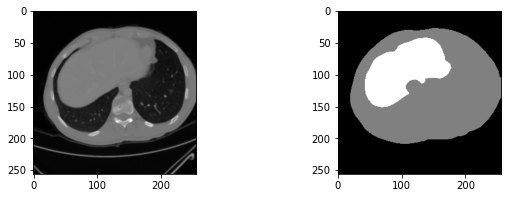

torch.Size([1, 256, 256]) torch.Size([1, 256, 256])
(array([22687,   951,   674,   488,   601, 25951, 13529,   498,   132,
          25]), array([0.        , 0.09998568, 0.19997136, 0.29995704, 0.39994273,
       0.4999284 , 0.5999141 , 0.6998998 , 0.79988545, 0.8998712 ,
       0.9998568 ], dtype=float32)) tensor([0., 1., 2.])


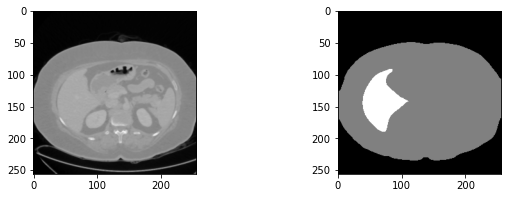

torch.Size([1, 256, 256]) torch.Size([1, 256, 256])
(array([32249,  1285,   917,   708, 20390,  9467,   392,    94,    22,
          12]), array([0.        , 0.09930621, 0.19861242, 0.29791865, 0.39722484,
       0.49653107, 0.5958373 , 0.6951435 , 0.7944497 , 0.8937559 ,
       0.99306214], dtype=float32)) tensor([0., 1., 2.])


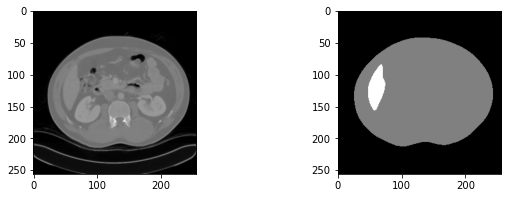

torch.Size([1, 256, 256]) torch.Size([1, 256, 256])
(array([27082, 13487,  1963,   951,  1231, 11872,  7711,   736,   391,
         112]), array([0.00356954, 0.10023797, 0.1969064 , 0.29357484, 0.39024326,
       0.48691168, 0.58358014, 0.68024856, 0.776917  , 0.8735854 ,
       0.9702538 ], dtype=float32)) tensor([0., 1.])


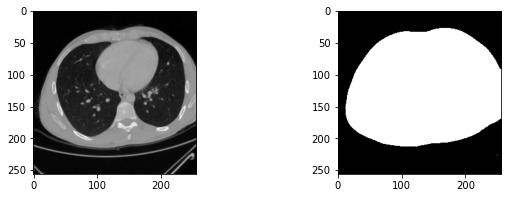

torch.Size([1, 256, 256]) torch.Size([1, 256, 256])
(array([29448,  4683,  3007,  1258,  1381, 15462,  9070,   993,   208,
          26]), array([0.        , 0.09947859, 0.19895719, 0.29843578, 0.39791438,
       0.49739298, 0.59687155, 0.69635016, 0.79582876, 0.89530736,
       0.99478596], dtype=float32)) tensor([0., 1., 2.])


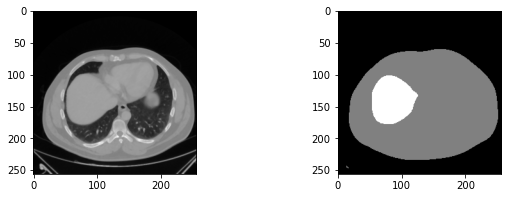

torch.Size([1, 256, 256]) torch.Size([1, 256, 256])
(array([14742, 14198,  3639,  1627,  6249, 20373,  4021,   381,   272,
          34]), array([0.        , 0.0992892 , 0.1985784 , 0.2978676 , 0.3971568 ,
       0.496446  , 0.5957352 , 0.69502443, 0.7943136 , 0.89360285,
       0.992892  ], dtype=float32)) tensor([0., 1., 2.])


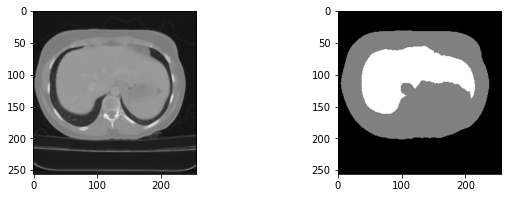

torch.Size([1, 256, 256]) torch.Size([1, 256, 256])
(array([31791,  1525,  1029,   652,   609,  3964, 17022,  8722,   177,
          45]), array([0.        , 0.09709597, 0.19419193, 0.2912879 , 0.38838387,
       0.48547983, 0.5825758 , 0.67967176, 0.77676773, 0.8738637 ,
       0.97095966], dtype=float32)) tensor([0., 1., 2.])


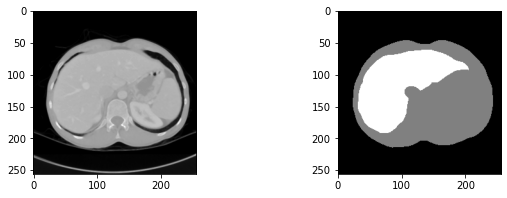

torch.Size([1, 256, 256]) torch.Size([1, 256, 256])
(array([33012,  1007,   703,   580, 14144, 14809,   962,   154,   132,
          33]), array([0.        , 0.09932595, 0.19865191, 0.29797786, 0.39730382,
       0.49662977, 0.5959557 , 0.6952817 , 0.79460764, 0.8939336 ,
       0.99325955], dtype=float32)) tensor([0., 1., 2.])


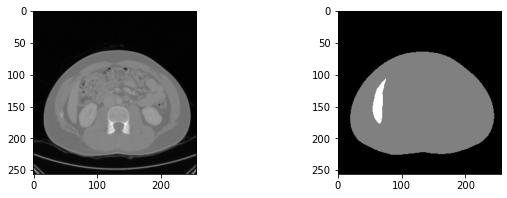

In [14]:
root = './data/CHAOS_AIAdatasets/2_Domain_Adaptation_dataset/CT/'
CT_data = getAllDataPath(root, test_split_size=0.2)
root = './data/CHAOS_AIAdatasets/2_Domain_Adaptation_dataset/MRI/MRI_Label/'
MRI_data = getAllDataPath(root, test_split_size=0.2)
root = './data/CHAOS_AIAdatasets/2_Domain_Adaptation_dataset/MRI/MRI_nonLabel/'
MRI_imgOnly_data = getAllDataPath(root, imgOnly=True)

for data in ['CT_data', 'MRI_data', 'MRI_imgOnly_data']:
    i = eval(data)
    for k in i.keys():
        print(data,k, np.shape(i[k]))


dataset_train = CustomImageDataset(MRI_data['train'], transform=transform, pseudo_label=True)
dataloader_train = torch.utils.data.DataLoader(dataset_train, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

dataset_test = CustomImageDataset(MRI_data['test'], transform=target_transform) # **如果要正式使用要記得把這裡換成X_test
dataloader_test = torch.utils.data.DataLoader(dataset_test, batch_size=BATCH_SIZE, shuffle=False)

CT_dataset_train = CustomImageDataset(CT_data['train'], transform=transform, pseudo_label=True)
CT_dataloader_train = torch.utils.data.DataLoader(CT_dataset_train, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

CT_dataset_test = CustomImageDataset(CT_data['test'], transform=target_transform)
CT_dataloader_test = torch.utils.data.DataLoader(CT_dataset_test, batch_size=BATCH_SIZE, shuffle=False)


for data in CT_dataloader_train:
    for x, y in zip(*data): 
        print(x.shape, y.shape)
        print(np.histogram(x.numpy()), y.unique())
        show_image(x.squeeze(0).numpy(), y.squeeze(0).numpy())

    break